# 국민청원 데이터로 청원 카테고리 분류하기

* 청원의 카테고리를 분류해 봅니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.23.4
1.14.6


In [2]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [0]:
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

# 데이터 로드하기
*  데이터 출처 : https://github.com/akngs/petitions

In [0]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 합니다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'
id = url.split('=')[1]
print(id)

1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4


In [6]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어온다.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('petition.csv')  
petitions = pd.read_csv('petition.csv',\
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 본다.
petitions.shape

(377756, 8)

In [7]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [8]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000) & (petitions['votes'] < 100000)].copy()
df.shape

(3235, 8)

In [9]:
df.describe()

,article_id,answered,votes
count,3235.000000,3235.0,3235.000000
mean,249593.362597,0.0,7331.565379
std,140415.115072,0.0,12544.876250
min,28.000000,0.0,1002.000000
25%,139117.000000,0.0,1546.500000
50%,241495.000000,0.0,2640.000000
75%,376506.000000,0.0,6478.000000
max,491954.000000,0.0,99947.000000


In [10]:
category_count = df['category'].value_counts()
category_count

인권/성평등         422
육아/교육          389
안전/환경          318
보건복지           314
교통/건축/국토       288
정치개혁           264
기타             254
문화/예술/체육/언론    189
외교/통일/국방       156
일자리            151
행정             148
반려동물           111
경제민주화          107
미래              52
성장동력            28
저출산/고령화대책       26
농산어촌            18
Name: category, dtype: int64

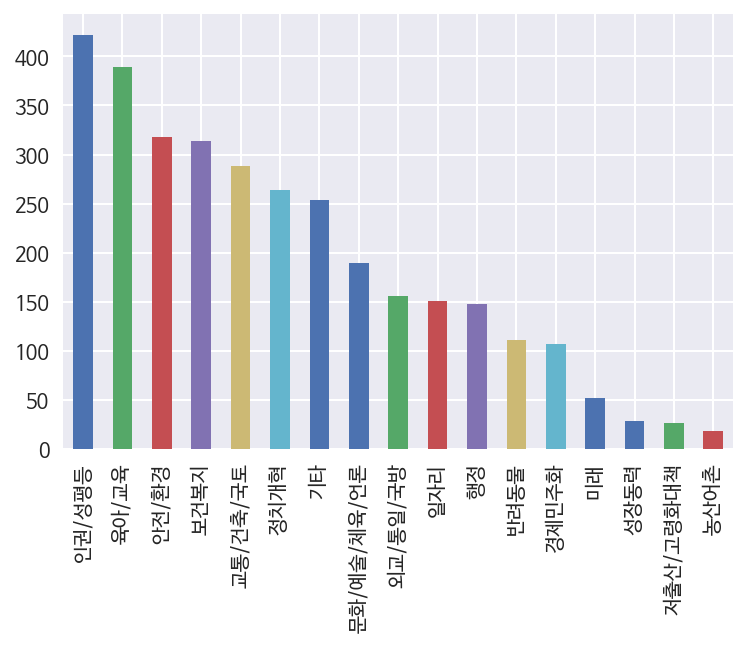

In [11]:
%matplotlib inline 
category_count.plot(kind='bar')

In [0]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [13]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [14]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0][0]
sample_index

28

In [15]:
sample_title = df['title'][sample_index]
sample_title

'치과위생사 국가고시 날짜 변경 억울합니다'

In [16]:
sample_content = petitions['content'][sample_index]
sample_content

'안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생입니다. 다름이 아니라 너무 억울한\\n일이 생겨  이렇게 글을 적어봅니다. 저희 3학년들은 올해 아주 중요한 시험이  있었습니다.3년동안 힘들게 고생하여 이제곧\\n끝난다.조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을\\n보내주었습니다. 그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다.국시원에서 국가고시 날짜가 변경 되었다.\\n그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다. 그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의 2번 국시를 볼수없다\\n그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년 18년 1월 5일이다 라는것입니다.\\n그 말을  듣고 더욱 이해할수가 없었습니다. 먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도\\n없고 그공지글도 그냥 통보였습니다. 국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게\\n말이 됩니까? 고등학생들이 보는 모의고사,수능도 이런식으로  변경 하지않습니다.  통보로 날짜를 변경하는건  저희\\n에비 의료기사들을 무시하는걸로 보입니다. 저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다. 하지만 저는  그러지 못할꺼같습니다.  아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다.\\n17년 12월16일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다. 공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요? 먼저 그날의 시험을 보기로 한 학생들은 저희입니다\\n왜 갑자기 저희가 양보해야하고  피해를봐야합니까?  저희국시 앞으로 4달남은상

# 전처리 하기 

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [0]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [0]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [0]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [21]:
pre_sample_content

'안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  치위생과  학년 학생입니다  다름이 아니라 너무 억울한 일이 생겨  이렇게 글을 적어봅니다  저희  학년들은 올해 아주 중요한 시험이  있었습니다  년동안 힘들게 고생하여 이제곧 끝난다 조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을 보내주었습니다  그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다 국시원에서 국가고시 날짜가 변경 되었다  그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다  그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의  번 국시를 볼수없다 그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년   년   일이다 라는것입니다  말을  듣고 더욱 이해할수가 없었습니다  먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도 없고 그공지글도 그냥 통보였습니다  국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게 말이 됩니까  고등학생들이 보는 모의고사 수능도 이런식으로  변경 하지않습니다   통보로 날짜를 변경하는건  저희 에비 의료기사들을 무시하는걸로 보입니다  저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다  하지만  그러지 못할꺼같습니다   아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다    년    일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들  공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요  먼저 그날의 시험을 보기로 학생들은 저희입니다 갑자기 저희가 양보해야하고  피해를봐야합니까   저희국시 앞으로  달남은상태였고 지금 학생들이 지쳐지만   월만 참으면 된다 라는 생각으로  견딘 학

In [22]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 484 ms, sys: 4.39 ms, total: 488 ms
Wall time: 1.21 s


In [23]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 1.15 s, sys: 16.6 ms, total: 1.16 s
Wall time: 3.26 s


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [0]:
df = df.reindex()

In [25]:
df.shape

(3235, 11)

In [26]:
split_count = int(df.shape[0] * 0.7)
split_count

2264

In [27]:
df_train = df[:split_count].copy()
df_train.shape

(2264, 11)

In [28]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [29]:
df_test = df[split_count:].copy()
df_test.shape

(971, 11)

In [30]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
265172,344518,2018-08-17,2018-09-16,0,1366,행정,동탄구청 설립 행정안전부에 승인요청,화성시 인구는 2018년 6월 기준 71만 5천626명입니다. 동탄 2신도시 입주로...,행정,화성시 인구는 년 월 기준 만 천 명입니다 동탄 신도시 입주로...,화성시 인구는 년 기준 만 천 명입니다 동탄 신도시 입주로 계...
265176,344522,2018-08-17,2018-09-16,0,15031,반려동물,강릉 고양이 토막사건,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다.\n같은 동물...,반려동물,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 같은 동물들...,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 동물들을 키...
265363,344741,2018-08-17,2018-09-16,0,2731,안전/환경,낙동강 보를 열어주세요,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다.\n낙동강 수질...,안전/환경,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다 낙동강 수질이...,경남 창원에서 낙동강 물로 두 아이를 키우고 엄마 낙동강 수질이 등급이라는 kb...
265471,344877,2018-08-17,2018-09-16,0,1629,행정,부동산 정책의 실패 애꿎은 중개업소에 전가말라.,부동산 정책의 실패 애꿎은 중개업소에 전가말라.\n의사 덕에 질병이 느는가?\n변호...,행정,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...
265856,345337,2018-08-17,2018-09-16,0,1285,성장동력,문대통령님 공약중에 하나인 계양테크노밸리 추진을 부탁드립니다,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,성장동력,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 계양테크노밸리 조...


## 카테고리 

In [31]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

,category_x,category_y
인권/성평등,297,0.131184
육아/교육,261,0.115283
안전/환경,219,0.096731
보건복지,219,0.096731
정치개혁,215,0.094965
기타,176,0.077739
교통/건축/국토,162,0.071555
문화/예술/체육/언론,144,0.063604
행정,114,0.050353
외교/통일/국방,107,0.047261


In [32]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)

,category_x,category_y
육아/교육,128,0.131823
교통/건축/국토,126,0.129763
인권/성평등,125,0.128733
안전/환경,99,0.101957
보건복지,95,0.097837
기타,78,0.080330
일자리,50,0.051493
정치개혁,49,0.050463
외교/통일/국방,49,0.050463
문화/예술/체육/언론,45,0.046344


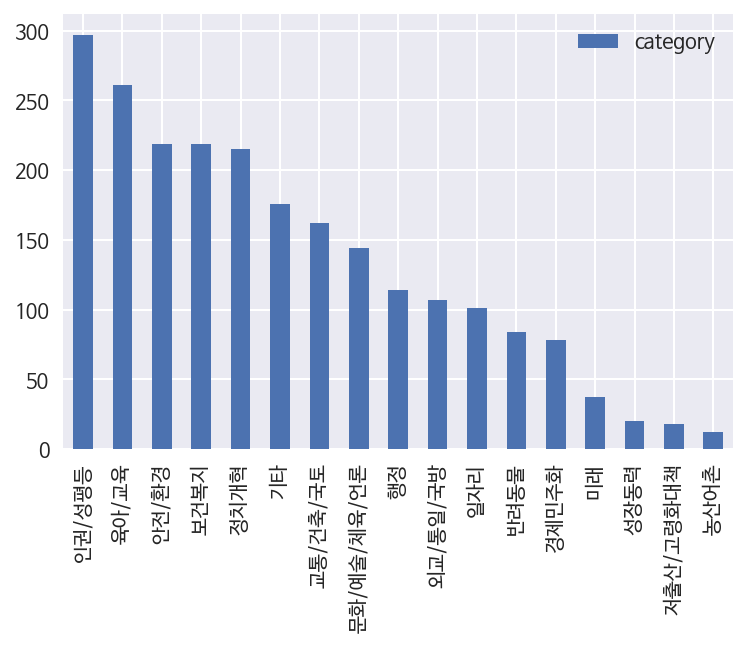

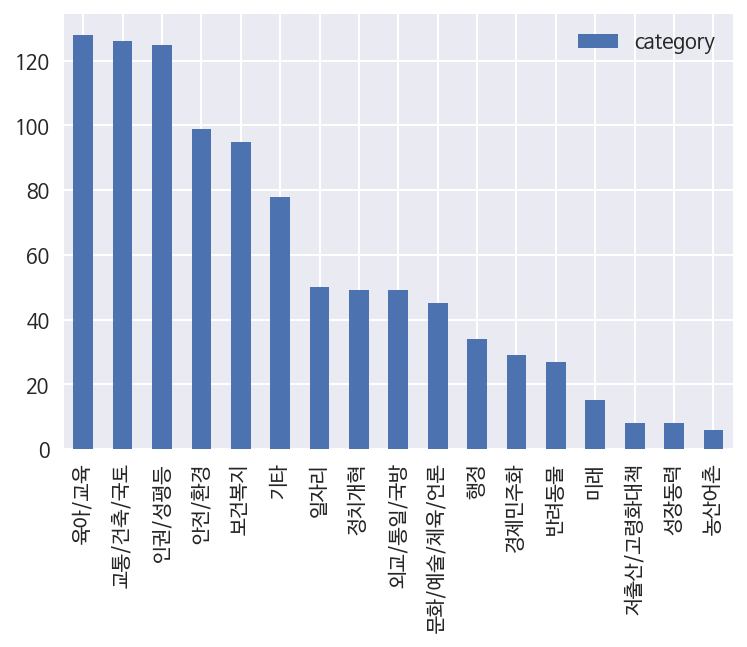

In [33]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [35]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 12 s, sys: 258 ms, total: 12.3 s
Wall time: 22.8 s


In [36]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 5.91 s, sys: 92.2 ms, total: 6 s
Wall time: 7.98 s


In [37]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'and',
 'article',
 'articleview',
 'articleview html',
 'articleview html idxno',
 'asp',
 'a는',
 'a의',
 'cctv']

In [38]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,and,article,articleview,articleview html,articleview html idxno,asp,a는,a의,cctv,...,훨씬,희망을,힘든,힘들게,힘들고,힘들어,힘듭니다,힘없는,힘을,힘이
0,87,69,53,77,60,60,38,36,168,161,...,49,75,62,141,84,38,44,38,90,62


In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [40]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 18.3 ms, sys: 20 µs, total: 18.3 ms
Wall time: 35.4 ms


In [41]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 10.6 ms, sys: 55 µs, total: 10.7 ms
Wall time: 13.2 ms


In [42]:
test_feature_tfidf.shape

(971, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [43]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [44]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 5.94 s, sys: 28.9 ms, total: 5.96 s
Wall time: 3.82 s


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면,
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [45]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 48.4 ms, sys: 101 ms, total: 150 ms
Wall time: 12 s


array([0.42163355, 0.401766  , 0.37969095, 0.42384106, 0.35176991])

In [46]:
round(np.mean(score)*100,2)

39.57

# 예측

In [47]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['기타', '반려동물', '교통/건축/국토'], dtype=object)

In [48]:
y_pred.shape

(971,)

In [49]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,기타
1,반려동물
2,교통/건축/국토
3,문화/예술/체육/언론
4,정치개혁


In [50]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

육아/교육          230
인권/성평등         169
보건복지           132
정치개혁           102
안전/환경           82
교통/건축/국토        63
반려동물            51
기타              43
문화/예술/체육/언론     36
경제민주화           29
외교/통일/국방        17
일자리              9
행정               7
미래               1
Name: category_pred, dtype: int64

In [0]:
df_test['category_pred'] = y_pred

In [52]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
265172,344518,2018-08-17,2018-09-16,0,1366,행정,동탄구청 설립 행정안전부에 승인요청,화성시 인구는 2018년 6월 기준 71만 5천626명입니다. 동탄 2신도시 입주로...,기타,화성시 인구는 년 월 기준 만 천 명입니다 동탄 신도시 입주로...,화성시 인구는 년 기준 만 천 명입니다 동탄 신도시 입주로 계...,0
265176,344522,2018-08-17,2018-09-16,0,15031,반려동물,강릉 고양이 토막사건,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다.\n같은 동물...,반려동물,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 같은 동물들...,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 동물들을 키...,1
265363,344741,2018-08-17,2018-09-16,0,2731,안전/환경,낙동강 보를 열어주세요,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다.\n낙동강 수질...,교통/건축/국토,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다 낙동강 수질이...,경남 창원에서 낙동강 물로 두 아이를 키우고 엄마 낙동강 수질이 등급이라는 kb...,0
265471,344877,2018-08-17,2018-09-16,0,1629,행정,부동산 정책의 실패 애꿎은 중개업소에 전가말라.,부동산 정책의 실패 애꿎은 중개업소에 전가말라.\n의사 덕에 질병이 느는가?\n변호...,문화/예술/체육/언론,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...,0
265856,345337,2018-08-17,2018-09-16,0,1285,성장동력,문대통령님 공약중에 하나인 계양테크노밸리 추진을 부탁드립니다,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,정치개혁,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 계양테크노밸리 조...,0


In [53]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    826
1    145
Name: pred_diff, dtype: int64

In [54]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 971건의 데이터 중 145건 예측


In [55]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 14.933058702368692


In [56]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
265176,344522,2018-08-17,2018-09-16,0,15031,반려동물,강릉 고양이 토막사건,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다.\n같은 동물...,반려동물,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 같은 동물들...,강릉 원주대에 새끼고양이 얼굴만남은채 캠퍼스안에 놓여진 사건이있습니다 동물들을 키...,1
266566,346274,2018-08-18,2018-09-17,0,4205,기타,새누리당 매크로 특검원합니다,이미 뉴스에 조작혐의 나온바 있는\n새누리당 매크로 특검 요청합니다\n대한민국의 모...,기타,이미 뉴스에 조작혐의 나온바 있는 새누리당 매크로 특검 요청합니다 대한민국의 모든 ...,이미 뉴스에 조작혐의 나온바 새누리당 매크로 특검 요청합니다 대한민국의 모든 적폐를...,1
267335,347320,2018-08-19,2018-09-18,0,2903,육아/교육,초등학생 중학생 등 미성년자의핸드폰중독으로 인한 불법사이트노출 교통사고등등 사회문제...,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록\n정부및 통신사에서\n도움 꼭 ...,육아/교육,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록 정부및 통신사에서 도움 꼭 부탁...,초등 중등 핸드폰 개통불가와 폴더폰으로 할수있도록 정부및 통신사에서 도움 꼭 부탁...,1
272890,354159,2018-08-24,2018-09-23,0,1193,육아/교육,학교가 지금 엉망이 되고 있습니다. 교권을 향상시키고 학생들에게 엄벌을 줘서 지도해주세요,학교가 지금 엉망이 되고 있습니다.\n수업중에 학생이 핸드폰을 키고 시끄럽게 떠드는...,육아/교육,학교가 지금 엉망이 되고 있습니다 수업중에 학생이 핸드폰을 키고 시끄럽게 떠드는가...,학교가 지금 엉망이 되고 수업중에 학생이 핸드폰을 키고 시끄럽게 떠드는가 하면 ...,1
274957,357015,2018-08-28,2018-09-27,0,5402,반려동물,청주반려동물센터 동물학대에 대한 철저한 조사 및 센터장 수의사 면허 취소를 청원합니다.,글을 쓰기에 앞서 이 글은 8월 25일자의 청원글을 참고하였고 최초의 글에서 누락된...,반려동물,글을 쓰기에 앞서 이 글은 월 일자의 청원글을 참고하였고 최초의 글에서 누락된...,글을 쓰기에 앞서 이 글은 일자의 청원글을 참고하였고 최초의 글에서 누락된 부...,1


In [57]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
265172,344518,2018-08-17,2018-09-16,0,1366,행정,동탄구청 설립 행정안전부에 승인요청,화성시 인구는 2018년 6월 기준 71만 5천626명입니다. 동탄 2신도시 입주로...,기타,화성시 인구는 년 월 기준 만 천 명입니다 동탄 신도시 입주로...,화성시 인구는 년 기준 만 천 명입니다 동탄 신도시 입주로 계...,0
265363,344741,2018-08-17,2018-09-16,0,2731,안전/환경,낙동강 보를 열어주세요,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다.\n낙동강 수질...,교통/건축/국토,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다 낙동강 수질이...,경남 창원에서 낙동강 물로 두 아이를 키우고 엄마 낙동강 수질이 등급이라는 kb...,0
265471,344877,2018-08-17,2018-09-16,0,1629,행정,부동산 정책의 실패 애꿎은 중개업소에 전가말라.,부동산 정책의 실패 애꿎은 중개업소에 전가말라.\n의사 덕에 질병이 느는가?\n변호...,문화/예술/체육/언론,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...,부동산 정책의 실패 애꿎은 중개업소에 전가말라 의사 덕에 질병이 느는가 변호사 ...,0
265856,345337,2018-08-17,2018-09-16,0,1285,성장동력,문대통령님 공약중에 하나인 계양테크노밸리 추진을 부탁드립니다,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,정치개혁,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 계양테크노밸리 조...,0
266082,345628,2018-08-18,2018-09-17,0,1809,교통/건축/국토,Sm5 차량 브레이크 불량관련 조사 꼭 해주세요,오늘 뉴스보니 sm5 차량 브레이크 불량관련 기사가 있더군요.. 저는 물론 sm5 ...,기타,오늘 뉴스보니 sm 차량 브레이크 불량관련 기사가 있더군요 저는 물론 sm ...,오늘 뉴스보니 sm 차량 브레이크 불량관련 기사가 있더군요 물론 sm 차량 ...,0


In [58]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

교통/건축/국토       113
인권/성평등          95
안전/환경           92
보건복지            80
육아/교육           76
기타              73
일자리             50
외교/통일/국방        47
문화/예술/체육/언론     42
정치개혁            40
행정              34
경제민주화           28
반려동물            19
미래              15
저출산/고령화대책        8
성장동력             8
농산어촌             6
Name: category, dtype: int64

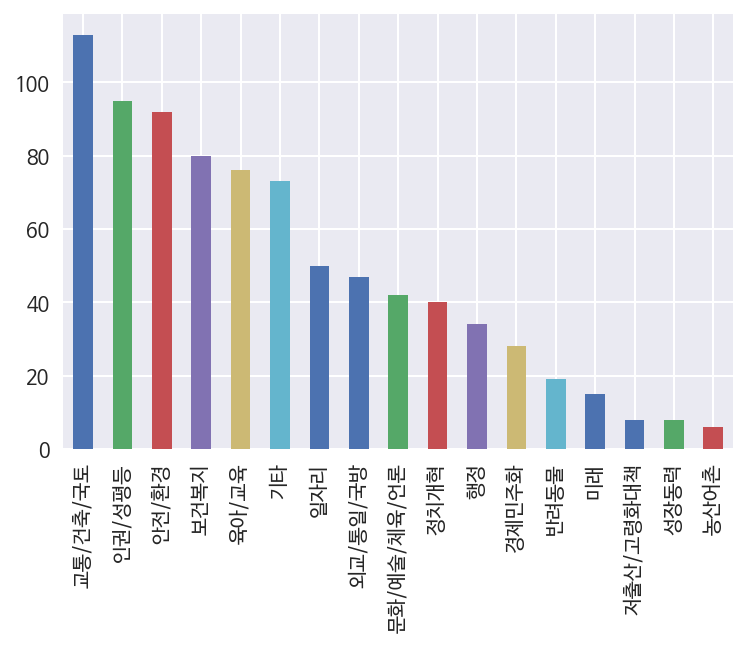

In [59]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [60]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
265172,행정,기타,동탄구청 설립 행정안전부에 승인요청,화성시 인구는 2018년 6월 기준 71만 5천626명입니다. 동탄 2신도시 입주로...
265363,안전/환경,교통/건축/국토,낙동강 보를 열어주세요,저는 경남 창원에서 낙동강 물로 두 아이를 키우고 있는 엄마 입니다.\n낙동강 수질...
265471,행정,문화/예술/체육/언론,부동산 정책의 실패 애꿎은 중개업소에 전가말라.,부동산 정책의 실패 애꿎은 중개업소에 전가말라.\n의사 덕에 질병이 느는가?\n변호...
265856,성장동력,정치개혁,문대통령님 공약중에 하나인 계양테크노밸리 추진을 부탁드립니다,문대통령님 선거 당시 지역개발 공약이자 송영길 의원의 공약이기도 한 계양테크노밸리...
266082,교통/건축/국토,기타,Sm5 차량 브레이크 불량관련 조사 꼭 해주세요,오늘 뉴스보니 sm5 차량 브레이크 불량관련 기사가 있더군요.. 저는 물론 sm5 ...
266109,보건복지,육아/교육,"사회복지사 처우개선, 시급합니다",안녕하세요?\n저희는 대전외국어고등학교 동아리 ‘공론장 속 지평융합’ 학생들입니다....
266499,인권/성평등,보건복지,여성가족부폐지를 대한민국정부에게 강력히 촉구합니다!!,대한민국을 휩쓸고 있는 예멘난민문제..누구보다 앞장서서 해결해야 하는 전담부서인 여...
266641,안전/환경,보건복지,의제강간연령을 만16세로 올려주세요!,안녕하십니까? 우연히 한 범죄심리학자분의 강연을 보다가 우리나라 의제강간연령이 만 ...
266936,인권/성평등,육아/교육,시대착오적이고 성차별적인 학교 복장 규정을 폐지해 주세요,안녕하세요. 저는 고등학교 1학년 학생입니다. 저는 학교에 다니면서 지금이 21세기...
267170,인권/성평등,안전/환경,"죽음으로 억울함을 호소한 어느 시내버스 기사의 사연, 시내버스 비리를 신고합니다.",어제 (8/16) 대전교통방송에서 대전 시내버스 기사가 사고를 내면 사고 처리에 드...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [61]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
271275,기타,인권/성평등,광양초남마을 우리 주민들 피해 구제 좀 해주세요,진실을 밝혀주세요 우리 초남마을 주민들 피해 구제 좀 해주세요\n안녕하세요\n저는 ...
271893,기타,육아/교육,경남도 내 고등학교도 휴교 부탁드립니다.,경남 진주의 한 고등학교에 재학 중인 학생입니다.\n7시 19분경 태풍 솔릭 북상에...
272760,기타,교통/건축/국토,사기의 형량을 높여주세요...피해자에게는 살인과 같습니다.,은행대출이 껴있지만 집도 있고 차도있고 아이둘에 행복한\n가족이였습니다...그사기꾼...
274932,기타,인권/성평등,세일전자 화재의 진상규명과 대표의 처벌을 요구합니다.,지난 21일 남동공단 세일전자에서 발생한 화재로 인해 9명이 사망하고 6명이 부상을...
277410,기타,안전/환경,인터넷방송 진실을 왜곡하고 구걸하는비제이방송,인터넷 유트부 방송비제이 복부인 강제구걸로 후원요구하는 비제이심각성을 다뤄 진정한 ...
278504,기타,육아/교육,삼성갤럭시s7메인보드결함,삼성전자 개x끼들 입니다\n삼성전자 갤럭시S7 일부 사용자들이 모바일 운영체제(OS...
279819,기타,인권/성평등,전통적 가정제도 부정하는 진선미 의원의 여가부 장관 지명 철회를 청원합니다,"대한민국에서 보편적인 혼인, 가족관으로 두 자녀를 키우고 있는 국민입니다. 그런데,..."
279982,기타,육아/교육,스포츠토토(베트맨) 국민 피 빨아먹는 짓 중단하게 해주세요,현재 한국의 스포츠토토는 10년이 훌쩍 지난 것으로 알고 있습니다. 하지만 최근에 ...
287766,기타,보건복지,대대적인 사기극에 휘말린것 같습니다.,대대적익 사기극에 휘말린거같아 민원드립니다.\n피해 본사람만해도 수백명입니다.\n리...
288502,기타,보건복지,의료사고로피눈물을흘리는사연들주세요,진 정 서\n수 신 : 문재인 대통령님\n참 조 : 비서실장님\n발 신 : ...
